In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings

# --- CẤU HÌNH ---
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid") # Format visualize mặc định
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

AUDIO_FOLDER = r"D:\HCMUS\HK8\ML Introduction\voice\extracted"
CSV_PATH = "visec_dataset.csv"

In [2]:
# --- 1. ĐỌC DỮ LIỆU ---
print(f"\n{'='*10} BÁO CÁO PHÂN TÍCH DỮ LIỆU {'='*10}")
df = pd.read_csv(CSV_PATH)


========== BÁO CÁO PHÂN TÍCH DỮ LIỆU ==========


In [3]:
print("\n--- Bảng thống kê Duration & RMS ---")
numeric_cols = ['duration', 'rms']
# Sử dụng describe() để tính toán nhanh, sau đó đổi tên cột
stats = df[numeric_cols].describe().T
stats['Variance'] = df[numeric_cols].var()
stats['IQR'] = stats['75%'] - stats['25%']
stats_display = stats[['mean', '50%', 'min', 'max', 'Variance', 'IQR']]
stats_display.columns = ['Trung bình', 'Trung vị', 'Thấp nhất', 'Cao nhất', 'Phương sai', 'IQR']
display(stats_display)


--- Bảng thống kê Duration & RMS ---


,Trung bình,Trung vị,Thấp nhất,Cao nhất,Phương sai,IQR
duration,2.1654,1.9445,1.0000,24.7040,1.5663,0.9600
rms,0.0621,0.0404,0.0033,0.4853,0.0036,0.0655


In [4]:
print("\n--- Phân bố Nhãn (Label) ---")
label_counts = df['label'].value_counts().to_frame(name='Số lượng')
label_counts['Tỉ lệ (%)'] = (label_counts['Số lượng'] / len(df) * 100).round(2)
display(label_counts)
print(f"► Tỉ lệ mất cân bằng (Max/Min): {label_counts['Số lượng'].max() / label_counts['Số lượng'].min():.2f}")


--- Phân bố Nhãn (Label) ---


,Số lượng,Tỉ lệ (%)
label,,
neutral,1507,28.5400
angry,1466,27.7700
happy,1228,23.2600
sad,1079,20.4400


► Tỉ lệ mất cân bằng (Max/Min): 1.40


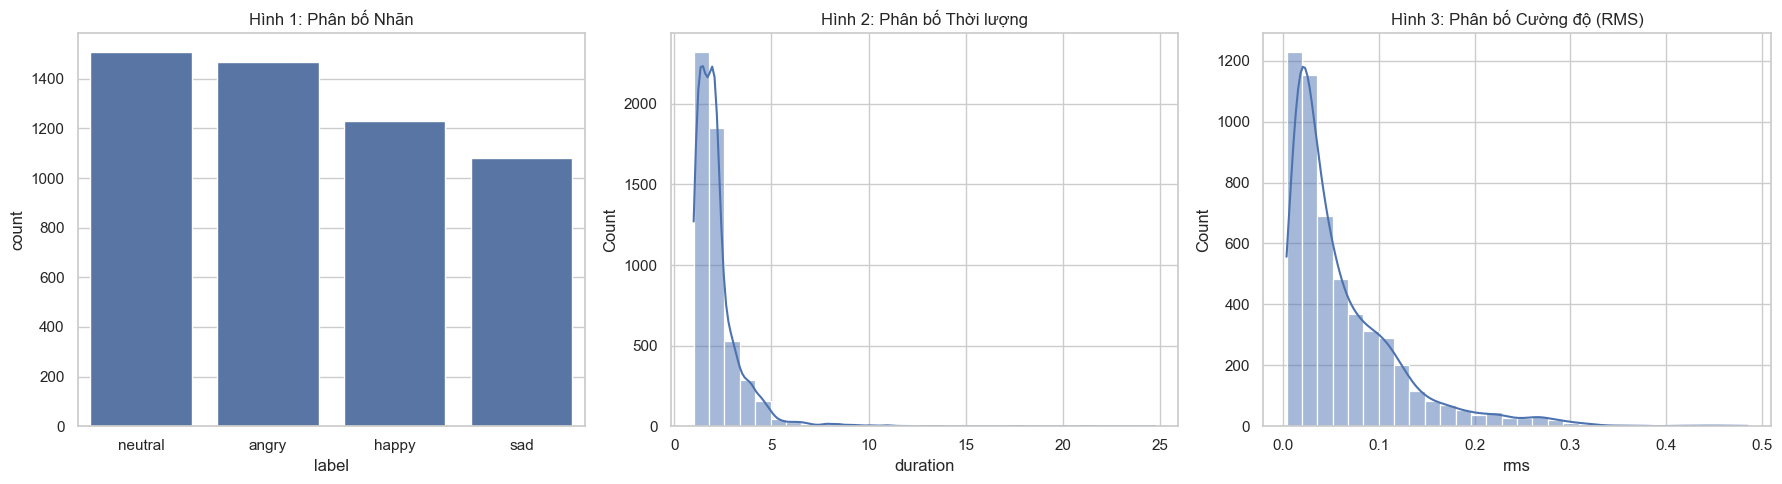

In [5]:
plt.figure(figsize=(18, 5))

# Phân bố nhãn
plt.subplot(1, 3, 1)
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title('Hình 1: Phân bố Nhãn')

# Phân bố Duration
plt.subplot(1, 3, 2)
sns.histplot(df['duration'], kde=True, bins=30)
plt.title('Hình 2: Phân bố Thời lượng')

# Phân bố RMS
plt.subplot(1, 3, 3)
sns.histplot(df['rms'], kde=True, bins=30)
plt.title('Hình 3: Phân bố Cường độ (RMS)')

plt.tight_layout()
plt.show()

In [6]:
print("\n--- Kiểm tra Đa cộng tuyến (VIF) ---")
X = add_constant(df[numeric_cols].dropna())
vif = pd.DataFrame()
vif["Đặc trưng"] = X.columns
vif["Hệ số VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
display(vif[vif["Đặc trưng"] != 'const'])


--- Kiểm tra Đa cộng tuyến (VIF) ---


,Đặc trưng,Hệ số VIF
1,duration,1.0083
2,rms,1.0083


In [7]:
print("\n--- Kiểm tra lỗi dữ liệu ---")
quality_check = pd.DataFrame({
    'Loại kiểm tra': ['Dữ liệu thiếu (dòng)', 'Dòng trùng lặp', 'File lỗi (0s)', 'File câm (RMS=0)', 'Sai tần số (khác 16k)'],
    'Số lượng': [
        df.isnull().any(axis=1).sum(),
        df.duplicated().sum(),
        (df['duration'] == 0).sum(),
        (df['rms'] == 0).sum(),
        (df['frequency'] != 16000).sum() if 'frequency' in df.columns else 0
    ]
})
display(quality_check)


--- Kiểm tra lỗi dữ liệu ---


,Loại kiểm tra,Số lượng
0,Dữ liệu thiếu (dòng),0
1,Dòng trùng lặp,0
2,File lỗi (0s),0
3,File câm (RMS=0),0
4,Sai tần số (khác 16k),0



--- Phân tích chi tiết 1 mẫu Audio ---
► Đang đọc file: 12_9.wav
► Nhãn: neutral


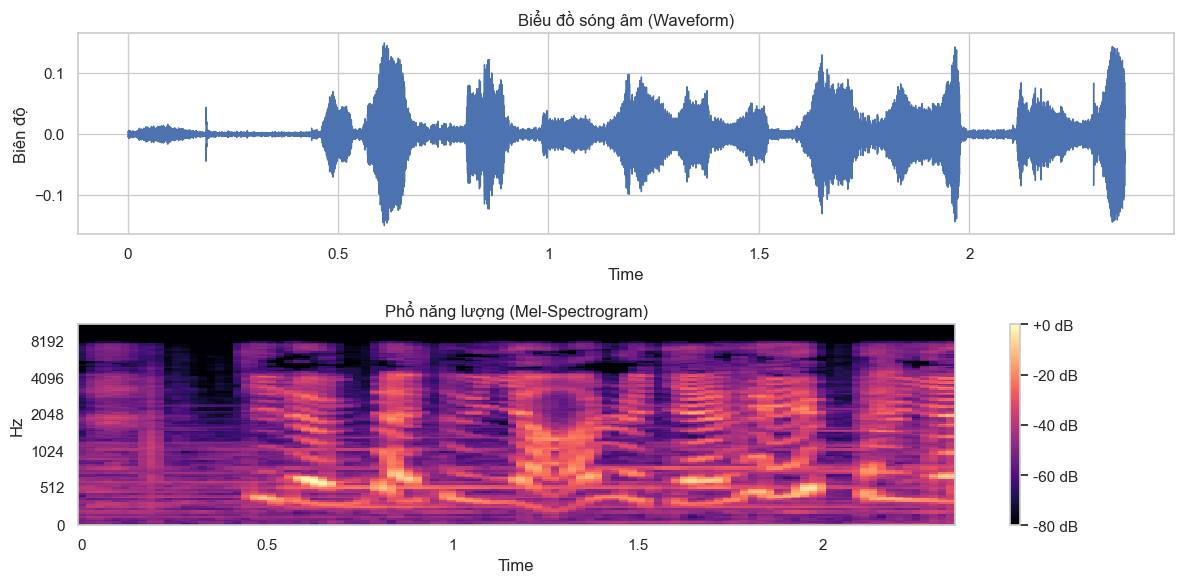

In [ ]:
print("\n--- Phân tích chi tiết 1 mẫu Audio ---")
sample = df.sample(1).iloc[0]


audio_path = os.path.join(AUDIO_FOLDER, str("12_9.wav")) 

print(f"► Đang đọc file: {os.path.basename(audio_path)}")
# print(f"► Nhãn: {sample['label']}")

y, sr = librosa.load(audio_path)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Biểu đồ sóng âm (Waveform)')
plt.ylabel('Biên độ')

plt.subplot(2, 1, 2)
S_db = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Phổ năng lượng (Mel-Spectrogram)')

plt.tight_layout()
plt.show()